# Create DRS+non-DRS dataset for haystack.deepset.ai
Per https://haystack.deepset.ai/tutorials/08_preprocessing, Haystack expects data to be provided as a list of documents in the following dictionary format. See also https://docs.haystack.deepset.ai/docs/document_store
```
docs = [
    {
        'content': DOCUMENT_TEXT_HERE,                                                              
        'meta': {'name': DOCUMENT_NAME, ...}
    }, ...
]
```

## Import DRS metadata

In [7]:
import pandas as pd
import numpy as np
import os
import glob

metadata_mapping = pd.read_excel(os.path.join(os.getcwd(),
                                              'data',
                                              'DRS',
                                              'index',
                                              'FAA DRS',
                                              'DRS Document Types Metadata Mapping.xlsx')) # from https://drs.faa.gov/help/helpdetails and https://drs.faa.gov/help/helpdetails

doc_types = pd.unique(metadata_mapping.loc[:, "Document Type Name in API request"])
doc_types = [val for val in doc_types if isinstance(val, str)]

common_fields = []
for n,doc_type in enumerate(doc_types):
    metadata_names = metadata_mapping.loc[metadata_mapping.loc[:, "Document Type Name in API request"]==doc_type, "Metadata Name in API Response "]

    if n>0:
        common_fields = list(set(metadata_names) & set(common_fields))
    else:
        common_fields = list(set(metadata_names))

Subset for which it was possible to split paragraphs

In [8]:
doc_types = ['AC',
            'ORDER_8300.10',
            'ORDER_8400.10',
            'ORDER_8700.1',
            'ORDER_8740.1',
            'ORDER_8900.1',
            'ORDERS']

In [9]:
df_drsmeta = None

for doc_type in doc_types:
    parquet_files = sorted(glob.glob(os.path.join(os.getcwd(),
                                                  'data', 
                                                  'DRS', 
                                                  'index', 
                                                  doc_type+'_202*.parquet')), 
                        key=os.path.getctime, 
                        reverse=True)

    if len(parquet_files)>0:
        this_parquet = pd.read_parquet(parquet_files[0])
        this_parquet.insert(0, 
                            "doc_type", 
                            value=pd.Series(data=doc_type, index=this_parquet.index, dtype="string"))

        if df_drsmeta is None:
            df_drsmeta = this_parquet
        else:
            df_drsmeta = pd.concat([this_parquet,
                                    df_drsmeta])

## Import DRS or non-DRS pre-dataset

In [10]:
# source_type = 'DRS'
source_type = 'NotInDRS'

In [11]:
import pandas as pd
import glob
import os

predatasets = sorted(glob.glob(os.path.join(os.getcwd(), 
                                            'data', 
                                            source_type, 
                                            'dataset', 
                                            'extracted_text', 
                                            '*.parquet')), 
                    key=os.path.getctime, 
                    reverse=True)
print(predatasets[0])
df_predataset = pd.read_parquet(predatasets[0])

df_predataset.tail()

c:\Users\victor\Documents\DeepLearning\FAA NLP Project\data\NotInDRS\dataset\extracted_text\extracted_text (augmented)_for_DocNotInDRS-20240128 - 213311.parquet


,filename,position in bookmark tree,original pdf bookmark title (outline.title),original pdf bookmark page number
1543,Pilot Controller Glossary Basic with Change 1.pdf,20,S,118
1544,Pilot Controller Glossary Basic with Change 1.pdf,21,T,130
1545,Pilot Controller Glossary Basic with Change 1.pdf,22,U,142
1546,Pilot Controller Glossary Basic with Change 1.pdf,23,V,144
1547,Pilot Controller Glossary Basic with Change 1.pdf,24,W,150


## Create dataset that is haystack.deepset friendly

In [12]:
if source_type=='DRS':
    df_dataset = pd.merge(df_predataset, df_drsmeta, on='documentGuid', how='inner').dropna(axis=1, how='all')
    df_dataset.insert(loc=0, column='content', value=pd.Series(df_dataset.shape[0]*[''], dtype="string"))
    df_dataset.insert(loc=0, column='parents_title_list', value=pd.Series(df_dataset.shape[0]*[''], dtype="string"))
elif source_type=='NotInDRS':
    df_dataset = df_predataset
    df_dataset.insert(loc=0, column='content', value=pd.Series(df_dataset.shape[0]*[''], dtype="string"))
    df_dataset.insert(loc=0, column='parents_title_list', value=pd.Series(df_dataset.shape[0]*[''], dtype="string"))
    df_dataset.insert(loc=0, column='drs:title', value=pd.Series(df_dataset['filename'].replace(to_replace=r'\.pdf$', value='', regex=True), dtype="string"))
    df_dataset.insert(loc=0, column='documentGuid', value=pd.Series(df_dataset['filename'].replace(to_replace=r'\.pdf$', value='', regex=True), dtype="string"))
    df_dataset.insert(loc=0, column='drs:status', value=pd.Series(df_dataset.shape[0]*['Current'], dtype="string"))
    df_dataset.insert(loc=0, column='doc_type', value=pd.Series(df_dataset.shape[0]*['NotInDRS'], dtype="string"))
    df_dataset.insert(loc=0, column='corrected pdf bookmark page number', value=pd.Series(df_dataset['original pdf bookmark page number'], dtype="string"))
    df_dataset.insert(loc=0, column='extracted title text', value=pd.Series(df_dataset['original pdf bookmark title (outline.title)'], dtype="string"))

In [ ]:
if source_type=='DRS':
    from PyPDF2 import PdfReader
elif source_type=='NotInDRS':
    from pypdf import PdfReader

import glob
import re
import logging
import datetime

logging.basicConfig(filename='94_make_datasets.log', encoding='utf-8',format='%(asctime)s %(message)s', level=logging.INFO)

def get_parents_title_list(position_in_bookmark_tree, df_dataset):
    parents_title_list = [df_dataset['drs:title'][0]]
    parent_title_number_list = position_in_bookmark_tree.split(">")

    for n in range(1,len(parent_title_number_list)+1):
        matching_index = df_dataset[df_dataset["position in bookmark tree"]==">".join(parent_title_number_list[0:n])].index[0]        
        parents_title_list.append(df_dataset.loc[matching_index, "original pdf bookmark title (outline.title)"])  # extracted title text extracted title number
        
    return str(parents_title_list)


def get_textcontent(pages, index, df_dataset, source_type):
    first_page = int(df_dataset.loc[index, 'corrected pdf bookmark page number'])

    if index in [df_dataset.shape[0]-1, df_dataset.index[-1]]:
        last_page = len(pages)-1 # index starts from 0
    else:
        try:
            last_page = int(df_dataset.loc[index+1, 'corrected pdf bookmark page number'])
        except Exception as e: # last bookmark
            n=1
            while (n<20):
                n = n+1
                try:
                    last_page = int(df_dataset.loc[index+n, 'corrected pdf bookmark page number'])
                    logging.info("Degraded mode for last_page, use different next index "+ str(n) + " with"+
                                "\ndocumentGuid="+df_dataset.loc[index+n, "documentGuid"]+
                                "\nposition in bookmark tree="+df_dataset.loc[index+n, "position in bookmark tree"]+
                                "\ntitle="+df_dataset.loc[index+n, "original pdf bookmark title (outline.title)"])
                    break
                except Exception as e:
                    pass                
            if n==20:
                last_page = len(pages)-1
                logging.info("Degraded mode for last_page, use len(pages)-1 with"+
                            "\ndocumentGuid="+df_dataset.loc[index, "documentGuid"])
                
    textcontent = []

    for n in range(first_page, last_page+1):
        if n==first_page:
            try:
                if source_type=='DRS':
                    re_search = re.search(re.escape(df_dataset.loc[index, 'first 20 characters after title']), 
                                        pages[n].extract_text())
                    start_textcontent = re_search.span()[0]
                elif source_type=='NotInDRS':
                    re_search = re.search(re.escape(df_dataset.loc[index, 'original pdf bookmark title (outline.title)']), 
                                        pages[n].extract_text())
                    start_textcontent = re_search.span()[-1]

            except Exception as e:
                logging.info("Error identifying start_textcontent with "+ e.args[0] +
                             "\ndocumentGuid="+df_dataset.loc[index, "documentGuid"]+
                             "\nfirst_page="+str(first_page)+
                             "\nposition in bookmark tree="+df_dataset.loc[index, "position in bookmark tree"]+
                             "\ntitle="+df_dataset.loc[index, "original pdf bookmark title (outline.title)"])
                start_textcontent = 0
        else:
            start_textcontent = 0

        if n==last_page:
            try:
                if source_type=='DRS':
                    re_search = re.search(re.escape(df_dataset.loc[index+1, 'extracted title number'])+
                                        '.{0,5}'+
                                        re.escape(df_dataset.loc[index+1, 'extracted title text']), 
                                        pages[n].extract_text())                                    
                    end_textcontent = re_search.span()[0]
                elif source_type=='NotInDRS':
                    re_search = re.search(re.escape(df_dataset.loc[index+1, 'original pdf bookmark title (outline.title)']), 
                                        pages[n].extract_text())
                    end_textcontent = re_search.span()[0]

            except Exception as e:
                logging.info("Error identifying end_textcontent with "+ e.args[0] +
                             "\ndocumentGuid="+df_dataset.loc[index, "documentGuid"]+
                             "\nlast_page="+str(last_page)+
                             "\nposition in bookmark tree="+df_dataset.loc[index, "position in bookmark tree"]+
                             "\ntitle="+df_dataset.loc[index, "original pdf bookmark title (outline.title)"])
                end_textcontent = None
        else:
            end_textcontent = None

        textcontent.append(pages[n].extract_text()[start_textcontent:end_textcontent])
            
    return str(textcontent)


for index, row in df_dataset.iterrows():
    matching_file = glob.glob(os.path.join(os.getcwd(), 'data', source_type, 'raw data', row["doc_type"], 'pdf', '*'+row['documentGuid']+'*.pdf'))
    if (len(matching_file)>0) and (row['drs:status']=='Current'):
        pdf = PdfReader(matching_file[0])
        df_dataset_filtered = df_dataset[df_dataset["documentGuid"]==row["documentGuid"]]

        try:
            df_dataset.at[index, 'parents_title_list'] = get_parents_title_list(row["position in bookmark tree"],
                                                                                df_dataset_filtered)        
            df_dataset.at[index, 'content'] = get_textcontent(pdf.pages, 
                                                              index, 
                                                              df_dataset_filtered,
                                                              source_type)
        except Exception as e:
            logging.info("Error with "+ e.args[0] +
                         "\ndocumentGuid="+df_dataset_filtered.loc[index, "documentGuid"]+
                         "\nposition in bookmark tree="+df_dataset_filtered.loc[index, "position in bookmark tree"]+
                         "\ntitle="+df_dataset_filtered.loc[index, "original pdf bookmark title (outline.title)"])


df_dataset.to_parquet(os.path.join(os.getcwd(),
                                   'data', 
                                   source_type, 
                                   'dataset',
                                   'dataset',
                                   'dataset_for_'+'-'.join(doc_types)+'-'+datetime.datetime.now().strftime("%Y%m%d - %H%M%S")+'.parquet'))

## Some metric
Number of documents total, number of documents per entry, histogram of number of words total, histogram of doc per doc type, nombre de doc pas dl

In [14]:
import pandas as pd
import glob
import os

datasets = sorted(glob.glob(os.path.join(os.getcwd(), 
                                         'data', 
                                         source_type, 
                                         'dataset', 
                                         'dataset', 
                                         '*.parquet')), 
                      key=os.path.getctime, 
                      reverse=True)
df_dataset = pd.read_parquet(datasets[0])

In [43]:
df_exploring = df_dataset[(300<df_nbwords) & (df_nbwords<400)][['documentGuid', 
                                                                'corrected pdf bookmark page number', 
                                                                'extracted title text', 
                                                                'parents_title_list',
                                                                'content']]

There are 22 documents over 1548 with less then 5 words extracted for all docs for NotInDRS documents


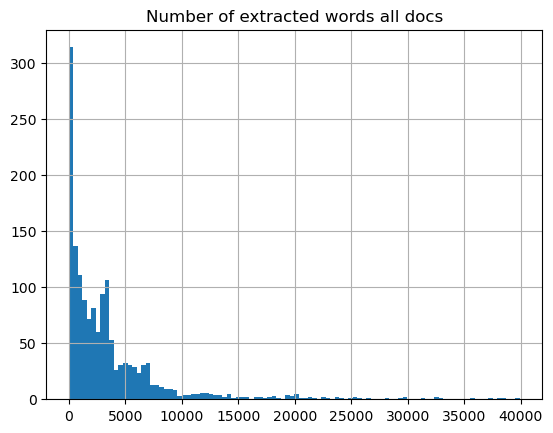

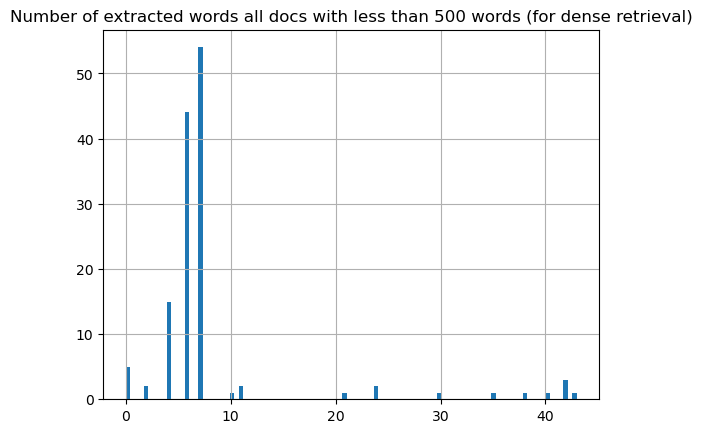

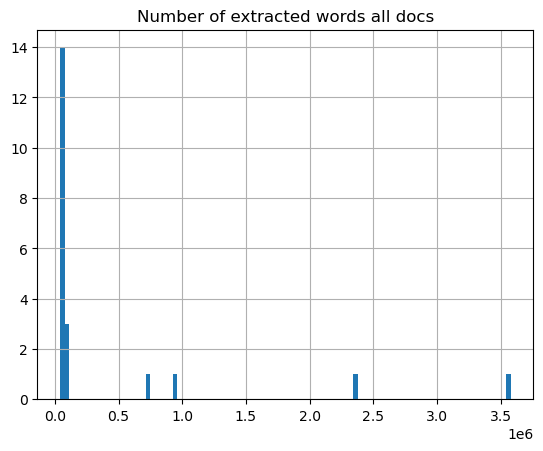

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 6.4, 4.8

nb_words = 5
nb_words_max = 40000 

# All docs
df_nbwords = df_dataset['content'].apply(len)
nb_zerowords_docs = df_nbwords[df_nbwords<nb_words].shape[0]
print('There are %s documents over %s with less then %s words extracted for all docs for %s documents' % 
      (nb_zerowords_docs, df_nbwords.shape[0], nb_words, source_type))

df_nbwords[df_nbwords<nb_words_max].hist(bins=100)
plt.title("Number of extracted words all docs")
plt.show()

ax = df_nbwords[df_nbwords<50].hist(bins=100)
plt.title("Number of extracted words all docs with less than 500 words (for dense retrieval)")
plt.show()

df_nbwords[df_nbwords>nb_words_max].hist(bins=100)
plt.title("Number of extracted words all docs")
plt.show()

df_dataset_manywords = df_dataset.loc[df_nbwords[df_nbwords>nb_words_max].index][['documentGuid', 
                                                                                  'corrected pdf bookmark page number', 
                                                                                  'extracted title text', 
                                                                                  'parents_title_list',
                                                                                  'content']]

# By doc for DRS
if source_type=='DRS':
    for doc_type in doc_types:
        df_nbwords = df_dataset.loc[df_dataset[df_dataset['doc_type']==doc_type].index, 'content'].apply(len)
        nb_zerowords_docs = df_nbwords[df_nbwords<nb_words].shape[0]
        print('There are %s documents over %s with less then %s words extracted for %s for %s documents' % 
              (nb_zerowords_docs, df_nbwords.shape[0], nb_words, doc_type, source_type))

        df_nbwords = df_nbwords[df_nbwords>=nb_words]
        df_nbwords.hist(bins=100) # .plot.bar() # plt.yticks(fontsize=10)
        plt.xlim(left=0, right=4000)
        plt.title("Number of extracted words for "+doc_type)
        plt.show()

## Exploring some examples to find patterns

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

nb_words = 5
fields = ['content', 'parents_title_list', 'documentURL']
df_dataset_debug = df_dataset[fields]
df_dataset_debug['size content'] = df_dataset['content'].apply(len)
df_dataset_debug = df_dataset_debug.sort_values(by=['size content'])

C:\Users\victor\AppData\Local\Temp\ipykernel_12708\3165917587.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset_debug['size content'] = df_dataset['content'].apply(len)


### Adding the FARs

In [1]:
import pandas as pd
import os
import glob
import datetime

parquet_files = sorted(glob.glob(os.path.join(os.getcwd(),
                                                'data', 
                                                'DRS', 
                                                'index', 
                                                'FAR_20*.parquet')), 
                    key=os.path.getctime, 
                    reverse=True)
print(parquet_files[0])
df_FAR_dataset = pd.read_parquet(parquet_files[0])
df_FAR_dataset.insert(loc=0, 
                      column='content', 
                      value=pd.Series(df_FAR_dataset.shape[0]*[''], dtype="string"))

for index, row in df_FAR_dataset.iterrows():
    file_matches = sorted(glob.glob(os.path.join(os.getcwd(),
                                                'data',
                                                'DRS',
                                                'raw data',
                                                'FAR',
                                                'pdf',
                                                '*'+row['documentGuid']+'.txt')
                                    ),
                                    key=os.path.getsize)
    if len(file_matches)>0:
        with open(file_matches[0], "r") as f:
            df_FAR_dataset.loc[index, 'content'] = f.read()

df_FAR_dataset.to_parquet(os.path.join(os.getcwd(),
                                       'data',
                                       'DRS', 
                                       'dataset',
                                       'FAR',
                                       'dataset_for_-FAR-'+datetime.datetime.now().strftime("%Y%m%d - %H%M%S")+'.parquet'))

c:\Users\victor\Documents\DeepLearning\FAA NLP Project\data\DRS\index\FAR_20240115 - 224301.parquet


c:\Users\victor\anaconda3\envs\faa-nlp-drs\Lib\site-packages\pyarrow\pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [2]:
import pandas as pd
import os
import glob
import datetime

predatasets = sorted(glob.glob(os.path.join(os.getcwd(), 
                                            'data', 
                                            'DRS', 
                                            'dataset', 
                                            'FAR', 
                                            'dataset_for_-FAR-*.parquet')), 
                    key=os.path.getctime, 
                    reverse=True)
print(predatasets[0])
df_FAR_dataset = pd.read_parquet(predatasets[0])

c:\Users\victor\Documents\DeepLearning\FAA NLP Project\data\DRS\dataset\FAR\dataset_for_-FAR-20240227 - 043028.parquet


## Dataset with AIP, AIM, FARs, ACs, Orders

In [3]:
import pandas as pd
import os
import glob

# DRS
predatasets = sorted(glob.glob(os.path.join(os.getcwd(), 
                                            'data', 
                                            'DRS', 
                                            'dataset', 
                                            'dataset', 
                                            '*.parquet')), 
                    key=os.path.getctime, 
                    reverse=True)
print(predatasets[0])
df_DRS_dataset = pd.read_parquet(predatasets[0])

# Non-DRS
predatasets = sorted(glob.glob(os.path.join(os.getcwd(), 
                                            'data', 
                                            'NotInDRS', 
                                            'dataset', 
                                            'dataset', 
                                            '*.parquet')), 
                    key=os.path.getctime, 
                    reverse=True)
print(predatasets[0])
df_NotInDRS_dataset = pd.read_parquet(predatasets[0])

# FAR
predatasets = sorted(glob.glob(os.path.join(os.getcwd(), 
                                            'data', 
                                            'DRS', 
                                            'dataset', 
                                            'FAR', 
                                            'dataset_for_-FAR-*.parquet')), 
                    key=os.path.getctime, 
                    reverse=True)
print(predatasets[0])
df_FAR_dataset = pd.read_parquet(predatasets[0])

# Together
df_dataset = pd.concat([df_DRS_dataset,
                        df_NotInDRS_dataset,
                        df_FAR_dataset])

df_dataset.to_parquet(os.path.join(os.getcwd(),
                                       'data',
                                       'DRS', 
                                       'dataset',
                                       'all_drs',
                                       'dataset_for_-FAR-ORDERS-ACs-AIP-AIM-'+datetime.datetime.now().strftime("%Y%m%d - %H%M%S")+'.parquet'))

c:\Users\victor\Documents\DeepLearning\FAA NLP Project\data\DRS\dataset\dataset\dataset_for_AC-ORDER_8300.10-ORDER_8400.10-ORDER_8700.1-ORDER_8740.1-ORDER_8900.1-ORDERS-20240127 - 111830.parquet
c:\Users\victor\Documents\DeepLearning\FAA NLP Project\data\NotInDRS\dataset\dataset\dataset_for_AC-ORDER_8300.10-ORDER_8400.10-ORDER_8700.1-ORDER_8740.1-ORDER_8900.1-ORDERS-20240128 - 221738.parquet
c:\Users\victor\Documents\DeepLearning\FAA NLP Project\data\DRS\dataset\FAR\dataset_for_-FAR-20240227 - 043028.parquet


c:\Users\victor\anaconda3\envs\faa-nlp-drs\Lib\site-packages\pyarrow\pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


# Other datasets format

In [1]:
import pandas as pd
import os
import glob
import datetime

predatasets = sorted(glob.glob(os.path.join(os.getcwd(), 
                                            'data', 
                                            'DRS', 
                                            'dataset', 
                                            'all_drs', 
                                            'dataset_for_-FAR-ORDERS-ACs-AIP-AIM-*.parquet')), 
                    key=os.path.getctime, 
                    reverse=True)
print(predatasets[0])
df_dataset = pd.read_parquet(predatasets[0])
df_dataset = df_dataset.reset_index()

/home/victor/NLP/FAA-NLP-Project/data/DRS/dataset/all_drs/dataset_for_-FAR-ORDERS-ACs-AIP-AIM-20240301 - 034459.parquet


In [2]:
df_dataset.iloc[4780][['index', 
                       'parents_title_list', 
                       'content', 
                       'documentGuid', 
                       'position in bookmark tree', 
                       'original pdf bookmark title (outline.title)', 
                       'original pdf bookmark page number', 
                       'corrected pdf bookmark page number', 
                       'extracted title number', 
                       'extracted title text', 
                       'first 20 characters after title', 
                       'nb_keywords for title search', 
                       'doc_type', 
                       'drs:documentNumber', 
                       'drs:status', 
                       'drs:title']]

index                                                                                       4780
parents_title_list                             [4304    Airworthiness Approval of Enhanced Vi...
content                                        ['4 CFR § 1.1) - A specified altitude in an in...
documentGuid                                                    C2774DBA5FFEE8D286258088005528A9
position in bookmark tree                                                          5>2>1>1>8>0>5
original pdf bookmark title (outline.title)    I.1.6 Decision Altitude (14 CFR § 1.1) - A spe...
original pdf bookmark page number                                                             94
corrected pdf bookmark page number                                                            94
extracted title number                                                                    I.1.6 
extracted title text                                                        Decision Altitude (1
first 20 characters after titl

## Word count filtering

In [ ]:
word_count_lower_limit = 30
word_count_upper_limit = 100000

## Generate JSONL
Axolotl [pre-training](https://openaccess-ai-collective.github.io/axolotl/docs/dataset-formats/pretraining.html):
`{"text": "first row"} {"text": "second row"}`

In [3]:
import pandas as pd
import os
import glob

df_jsonl = df_dataset[["drs:title", "parents_title_list", "content"]]
df_jsonl = df_jsonl.loc[word_count_lower_limit<df_jsonl["content"].str.len()]
df_jsonl = df_jsonl.loc[df_jsonl["content"].str.len()<word_count_upper_limit]

df_jsonl_title = df_jsonl["drs:title"].map(lambda x: "title:\n "+x+"\n\n")
df_jsonl_parents_title_list = df_jsonl["parents_title_list"].map(lambda x: "document context and subtitles:\n "+'; '.join(x[2:-2].split('dtype: string')[-1].split(', '))+"\n\n" 
                                                                               if str(x)!='<NA>' 
                                                                               else "")
df_jsonl_content = df_jsonl["content"].map(lambda x: "content:\n "+' '.join(x[2:-2].split(', ')))

df_jsonl = pd.Series(df_jsonl_title+df_jsonl_parents_title_list+df_jsonl_content,
                     name="text").to_frame()

df_jsonl.to_json(os.path.join(os.getcwd(),
                            'data',
                            'DRS', 
                            'dataset',
                            'all_drs',
                            'dataset_axolotl-pretraining_for_FAR-ORDERS-ACs-AIP-AIM-'+datetime.datetime.now().strftime("%Y%m%d - %H%M%S")+'.jsonl'),
                orient='records', 
                lines=True)

Axolotl [oasst](https://openaccess-ai-collective.github.io/axolotl/docs/dataset-formats/inst_tune.html#oasst) fine-tuning:
`{"INSTRUCTION": "...", "RESPONSE": "..."}`

In [21]:
import pandas as pd
import os
import glob

df_jsonl = df_dataset[["drs:title", "parents_title_list", "content"]]
df_jsonl = df_jsonl.loc[word_count_lower_limit<df_jsonl["content"].str.len()]
df_jsonl = df_jsonl.loc[df_jsonl["content"].str.len()<word_count_upper_limit]

df_jsonl_title = df_jsonl["drs:title"].map(lambda x: "title:\n "+x+"\n\n").astype("string")
df_jsonl_parents_title_list = df_jsonl["parents_title_list"].map(lambda x: "document context:\n "+'; '.join(x[2:-2].split('dtype: string')[-1].split(', '))+"\n\n" 
                                                                               if str(x)!='<NA>' 
                                                                               else "").astype("string")
df_jsonl_content = df_jsonl["content"].map(lambda x: ' '.join(x[2:-2].split(', '))).astype("string")


INSTRUCTION_introduction = 'Can you provide more explanations given the following title and document context.\n\n'
df_jsonl_INSTRUCTION = pd.Series(INSTRUCTION_introduction+df_jsonl_title+df_jsonl_parents_title_list, 
                                 dtype="string",
                                 name="INSTRUCTION").astype("string").to_frame()
df_jsonl_RESPONSE = pd.Series(df_jsonl_content,
                              dtype="string",
                              name="RESPONSE").astype("string").to_frame()
df_jsonl = pd.concat([df_jsonl_INSTRUCTION["INSTRUCTION"], df_jsonl_RESPONSE["RESPONSE"]], axis=1)

df_jsonl.to_json(os.path.join(os.getcwd(),
                            'data',
                            'DRS', 
                            'dataset',
                            'all_drs',
                            'dataset_axolotl-finetuning_for_FAR-ORDERS-ACs-AIP-AIM-'+datetime.datetime.now().strftime("%Y%m%d - %H%M%S")+'.jsonl'),
                orient='records', 
                lines=True)

## Generate CSV
For [Gemini](https://developers.googleblog.com/2024/03/tune-gemini-pro-in-google-ai-studio-or-gemini-api.html)

In [7]:
import pandas as pd
import os
import glob

df_jsonl = df_dataset[["drs:title", "parents_title_list", "content"]]
df_jsonl = df_jsonl.loc[word_count_lower_limit<df_jsonl["content"].str.len()]
df_jsonl = df_jsonl.loc[df_jsonl["content"].str.len()<word_count_upper_limit]

df_jsonl_title = df_jsonl["drs:title"].map(lambda x: "title:\n "+x+"\n\n")
df_jsonl_parents_title_list = df_jsonl["parents_title_list"].map(lambda x: "document context and subtitles:\n "+'; '.join(x[2:-2].split('dtype: string')[-1].split(', '))+"\n\n" 
                                                                               if str(x)!='<NA>' 
                                                                               else "")
df_jsonl_content = df_jsonl["content"].map(lambda x: "content:\n "+' '.join(x[2:-2].split(', ')))

df_jsonl = df_jsonl_title+df_jsonl_parents_title_list+df_jsonl_content

df_jsonl.to_csv(os.path.join(os.getcwd(),
                            'data',
                            'DRS', 
                            'dataset',
                            'all_drs',
                            'dataset_gemini_for_FAR-ORDERS-ACs-AIP-AIM-'+datetime.datetime.now().strftime("%Y%m%d - %H%M%S")+'.csv'),
                index=False)